<a href="https://colab.research.google.com/github/AK18k/ex2/blob/main/ex2_028064558_027244037_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning - Ex #2
Avi Keinan 028064558
Ofer Ballin 027244037

This notebook implements LSTM and GRU with and without dropouts

In [ ]:
%load_ext google.colab.data_table
import pdb

In [1]:
!git clone https://github.com/AK18k/ex2

Cloning into 'ex2'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 93 (delta 36), reused 38 (delta 1), pack-reused 0
Unpacking objects: 100% (93/93), 3.84 MiB | 6.46 MiB/s, done.


In [2]:
import os
from google.colab import drive
#drive.mount('/content/drive')
DATA_PATH = '/content/ex2/data/ptb'
PATH = '/content/ex2'
os.chdir('/content/ex2')
!ls

adabound.py				      finetune.py	 model.py
corpus.77afd5b9c5825ef44c47fcd18f4839dd.data  generate.py	 pointer.py
data					      getdata.sh	 README.md
data.py					      LICENSE		 splitcross.py
embed_regularize.py			      locked_dropout.py  utils.py
ex2_028064558_027244037_new.ipynb	      main.py		 weight_drop.py


In [3]:
import sys
sys.path.insert(0, '/content/ex2')

In [4]:
import argparse
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from adabound import AdaBound

import data
import model

from utils import batchify, get_batch, repackage_hidden

In [5]:
parser = argparse.ArgumentParser(description='PyTorch PennTreeBank RNN/LSTM Language Model')
parser.add_argument('--data', type=str, default='data/ptb/',
                    help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM',
                    help='type of recurrent net (LSTM, QRNN, GRU)')
parser.add_argument('--emsize', type=int, default=1500,
                    help='size of word embeddings')
parser.add_argument('--nhid', type=int, default=200,
                    help='number of hidden units per layer')
parser.add_argument('--nlayers', type=int, default=2,
                    help='number of layers')
parser.add_argument('--lr', type=float, default=0.1,
                    help='initial learning rate')
# parser.add_argument('--clip', type=float, default=0.25,
#                     help='gradient clipping')
parser.add_argument('--epochs', type=int, default=200,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=20, metavar='N',
                    help='batch size')
parser.add_argument('--bptt', type=int, default=35,
                    help='sequence length')
parser.add_argument('--dropout', type=float, default=0,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--dropouth', type=float, default=0,
                    help='dropout for rnn layers (0 = no dropout)')
parser.add_argument('--dropouti', type=float, default=0,
                    help='dropout for input embedding layers (0 = no dropout)')
parser.add_argument('--dropoute', type=float, default=0,
                    help='dropout to remove words from embedding layer (0 = no dropout)')
parser.add_argument('--wdrop', type=float, default=0,
                    help='amount of weight dropout to apply to the RNN hidden to hidden matrix')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--nonmono', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_false',
                    help='use CUDA')
parser.add_argument('--log-interval', type=int, default=200, metavar='N',
                    help='report interval')
randomhash = ''.join(str(time.time()).split('.'))
parser.add_argument('--save', type=str,  default=randomhash+'.pt',
                    help='path to save the final model')
parser.add_argument('--alpha', type=float, default=2,
                    help='alpha L2 regularization on RNN activation (alpha = 0 means no regularization)')
parser.add_argument('--beta', type=float, default=1,
                    help='beta slowness regularization applied on RNN activiation (beta = 0 means no regularization)')
parser.add_argument('--wdecay', type=float, default=5e-4,
                    help='weight decay applied to all weights')
parser.add_argument('--resume', type=str,  default='',
                    help='path of model to resume')
parser.add_argument('--when', nargs="+", type=int, default=[-1],
                    help='When (which epochs) to divide the learning rate by 10 - accepts multiple')
parser.add_argument('--optim', default='sgd', type=str, help='optimizer',
                    choices=['sgd', 'adagrad', 'adam', 'amsgrad', 'adabound', 'amsbound'])
parser.add_argument('--momentum', default=0.9, type=float, help='momentum term')
parser.add_argument('--beta1', default=0.9, type=float, help='Adam coefficients beta_1')
parser.add_argument('--beta2', default=0.999, type=float, help='Adam coefficients beta_2')
parser.add_argument('--final_lr', default=0.1, type=float,
                    help='final learning rate of AdaBound')
parser.add_argument('--gamma', default=1e-3, type=float,)
parser.add_argument('--ita',default=1e-2, type=float)
parser.add_argument('--weight_decay', default=5e-4, type=float,
                    help='weight decay for optimizers')
#args = parser.parse_args()
args, unknown = parser.parse_known_args() #change args assignment to accomodate Jupiter execution (instead of command line)
args.tied = True

# Set the random seed manually for reproducibility.
np.random.seed(args.seed)
torch.manual_seed(args.seed)
print(args.cuda)
if torch.cuda.is_available():
    print('cuda is available')
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)




True
cuda is available


In [9]:
print(type(args.model))



<class 'str'>


In [10]:

###############################################################################
# Load data
###############################################################################

def model_save(fn):
    with open(fn, 'wb') as f:
        torch.save([model, criterion, optimizer], f)

def model_load(fn):
    global model, criterion, optimizer
    with open(fn, 'rb') as f:
        model, criterion, optimizer = torch.load(f)

import os
import hashlib
fn = 'corpus.{}.data'.format(hashlib.md5(args.data.encode()).hexdigest())
if os.path.exists(fn):
    print('Loading cached dataset...')
    corpus = torch.load(fn)
else:
    print('Producing dataset...')
    corpus = data.Corpus(args.data)
    torch.save(corpus, fn)

eval_batch_size = 10

test_batch_size = 1
train_data = batchify(corpus.train, args.batch_size, args)
val_data = batchify(corpus.valid, eval_batch_size, args)
test_data = batchify(corpus.test, test_batch_size, args)




Loading cached dataset...


In [ ]:
print(train_data.shape)
print(args.batch_size)
print(train_data[0][2].shape)
print(args)

torch.Size([46479, 20])
20
torch.Size([])
Namespace(data='data/ptb/', model='LSTM', emsize=1500, nhid=650, nlayers=2, lr=0.1, epochs=200, batch_size=20, bptt=35, dropout=0, dropouth=0, dropouti=0, dropoute=0, wdrop=0, seed=1111, nonmono=1111, cuda=True, log_interval=200, save='16849330738481638.pt', alpha=2, beta=1, wdecay=0.0005, resume='', when=[-1], optim='sgd', momentum=0.9, beta1=0.9, beta2=0.999, final_lr=0.1, gamma=0.001, ita=0.01, weight_decay=0.0005, tied=True)


In [11]:
#@title
###############################################################################
# Build the model
###############################################################################

from splitcross import SplitCrossEntropyLoss
criterion = None

ntokens = len(corpus.dictionary)
model = model.RNNModel(args.model, ntokens, args.emsize, args.nhid, args.nlayers, args.dropout, args.dropouth, args.dropouti, args.dropoute, args.wdrop, args.tied)
###
if args.resume:
    print('Resuming model ...')
    model_load(args.resume)
    optimizer.param_groups[0]['lr'] = args.lr
    model.dropouti, model.dropouth, model.dropout, args.dropoute = args.dropouti, args.dropouth, args.dropout, args.dropoute
    if args.wdrop:
        from weight_drop import WeightDrop
        for rnn in model.rnns:
            if type(rnn) == WeightDrop: rnn.dropout = args.wdrop
            elif rnn.zoneout > 0: rnn.zoneout = args.wdrop
###
if not criterion:
    splits = []
    if ntokens > 500000:
        # One Billion
        # This produces fairly even matrix mults for the buckets:
        # 0: 11723136, 1: 10854630, 2: 11270961, 3: 11219422
        splits = [4200, 35000, 180000]
    elif ntokens > 75000:
        # WikiText-103
        splits = [2800, 20000, 76000]
    print('Using', splits)
    criterion = SplitCrossEntropyLoss(args.emsize, splits=splits, verbose=False)
###
if args.cuda:
    model = model.cuda()
    criterion = criterion.cuda()
###
params = list(model.parameters()) + list(criterion.parameters())
total_params = sum(x.size()[0] * x.size()[1] if len(x.size()) > 1 else x.size()[0] for x in params if x.size())
print('Args:', args)
print('Model total parameters:', total_params)

[LSTM(1500, 200), LSTM(200, 1500)]
Using []
Args: Namespace(data='data/ptb/', model='LSTM', emsize=1500, nhid=200, nlayers=2, lr=0.1, epochs=200, batch_size=20, bptt=35, dropout=0, dropouth=0, dropouti=0, dropoute=0, wdrop=0, seed=1111, nonmono=1111, cuda=True, log_interval=200, save='16849422630013726.pt', alpha=2, beta=1, wdecay=0.0005, resume='', when=[-1], optim='sgd', momentum=0.9, beta1=0.9, beta2=0.999, final_lr=0.1, gamma=0.001, ita=0.01, weight_decay=0.0005, tied=True)
Model total parameters: 26583600


In [15]:
###############################################################################
# Build and print Results Matrix
###############################################################################


import math
import numpy as np
import matplotlib.pyplot as plt

class Result_Matrix:
    def __init__(self, model_type):
      self.model_name = model_type
      self.nepochs = 0
      self.train_ppl = np.array([])
      self.val_ppl = np.array([])
      self.test_ppl = np.array([])
      self.drop = args.dropout != 0

    def add_result(self, result, result_type = 'train'):
      if result_type == 'train':
        self.train_ppl = np.append(self.train_ppl, result)
      elif result_type == 'val':
        self.val_ppl = np.append(self.val_ppl, result)
      elif result_type == 'test':
        self.test_ppl = np.append(self.test_ppl, result)

    def get_results(self, result_type = 'train'):
      if result_type == 'train':
        return(self.train_ppl)
      elif result_type == 'val':
        return(self.val_ppl)
      elif result_type == 'test':
        return(self.test_ppl) 


def plot_results(result_matrix):
  plt.figure()
  y = result_matrix.get_results('train')
  plt.plot(np.arange(1,len(y)+1), y, label = 'train', color = 'blue')
  y = result_matrix.get_results('val')
  plt.plot(np.arange(1,len(y)+1), y, label = 'val', color = 'green')
  y = result_matrix.get_results('test')
  plt.plot(np.arange(1,len(y)+1), y, label = 'test', color = 'red')
  plt.legend()
  plt.title(f'Model Type = {result_matrix.model_name}. dropout = {result_matrix.drop}')
  #plt.ylim((0.75, 1))
  plt.xlabel('eoch')
  plt.ylabel('perplexity')
  plt.grid()
  plt.show()  



epoch:1
train_loss   6.53 | train_ppl   688.41 | train_bpc    9.427
-----------------------------------------------------------------------------------------
 valid loss  6.29 | valid ppl   539.57 | valid bpc    9.076
-----------------------------------------------------------------------------------------
Saving model (new best validation)
epoch:2
train_loss   6.05 | train_ppl   422.65 | train_bpc    8.723
-----------------------------------------------------------------------------------------
 valid loss  5.91 | valid ppl   367.13 | valid bpc    8.520
-----------------------------------------------------------------------------------------
Saving model (new best validation)
epoch:3
train_loss   5.79 | train_ppl   328.25 | train_bpc    8.359
-----------------------------------------------------------------------------------------
 valid loss  5.79 | valid ppl   327.03 | valid bpc    8.353
-----------------------------------------------------------------------------------------
Saving

NameError: ignored

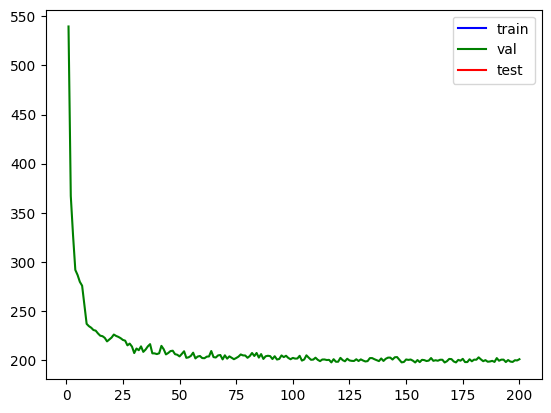

In [14]:

###############################################################################
# Training code
###############################################################################

def evaluate(data_source, batch_size=10):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    if args.model == 'QRNN': model.reset()
    total_loss = 0
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    for i in range(0, data_source.size(0) - 1, args.bptt):
        data, targets = get_batch(data_source, i, args, evaluation=True)       
        output, hidden = model(data, hidden)
        total_loss += len(data) * criterion(model.decoder.weight, model.decoder.bias, output, targets).data
        hidden = repackage_hidden(hidden)
    return total_loss.item() / len(data_source)


def train():
    # Turn on training mode which enables dropout.
    if args.model == 'QRNN': model.reset()
    total_loss = 0
    # start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(args.batch_size)
    batch, i = 0, 0
    while i < train_data.size(0) - 1 - 1:
        # bptt = args.bptt if np.random.random() < 0.95 else args.bptt / 2. avi keinan
        bptt = args.bptt        
        # Prevent excessively small or negative sequence lengths
        # seq_len = max(5, int(np.random.normal(bptt, 5))) avi keinan
        seq_len = bptt
        # There's a very small chance that it could select a very long sequence length resulting in OOM
        # seq_len = min(seq_len, args.bptt + 10)

        lr2 = optimizer.param_groups[0]['lr']
        optimizer.param_groups[0]['lr'] = lr2 * seq_len / args.bptt
        model.train()
        data, targets = get_batch(train_data, i, args, seq_len=seq_len)

        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()

        output, hidden, rnn_hs, dropped_rnn_hs = model(data, hidden, return_h=True)
        raw_loss = criterion(model.decoder.weight, model.decoder.bias, output, targets)

        loss = raw_loss
        # Activiation Regularization
        if args.alpha: loss = loss + sum(args.alpha * dropped_rnn_h.pow(2).mean() for dropped_rnn_h in dropped_rnn_hs[-1:])
        # Temporal Activation Regularization (slowness)
        if args.beta: loss = loss + sum(args.beta * (rnn_h[1:] - rnn_h[:-1]).pow(2).mean() for rnn_h in rnn_hs[-1:])
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # if args.clip: torch.nn.utils.clip_grad_norm_(params, args.clip)
        optimizer.step()

        total_loss += raw_loss.data
        optimizer.param_groups[0]['lr'] = lr2
        # if batch % args.log_interval == 0 and batch > 0:
        # total_loss = 0
            # start_time = time.time()
        ###
        batch += 1
        i += seq_len

    train_loss = total_loss.item() / batch
    # elapsed = time.time() - start_time
    print('train_loss  {:5.2f} | train_ppl {:8.2f} | train_bpc {:8.3f}'.format(
        train_loss, math.exp(train_loss), train_loss / math.log(2)))
    results_m.add_result(math.exp(train_loss), 'train') #add train ppl to result matrix
# Loop over epochs.
lr = args.lr
best_val_loss = []
stored_loss = 100000000

def create_optimizer(args, model_params):
    if args.optim == 'sgd':
        return optim.SGD(model_params, args.lr, momentum=args.momentum,
                         weight_decay=args.weight_decay)
    elif args.optim == 'adagrad':
        return optim.Adagrad(model_params, args.lr, weight_decay=args.weight_decay)
    elif args.optim == 'adam':
        return optim.Adam(model_params, args.lr, betas=(args.beta1, args.beta2),
                          weight_decay=args.weight_decay)
    elif args.optim == 'amsgrad':
        return optim.Adam(model_params, args.lr, betas=(args.beta1, args.beta2),
                          weight_decay=args.weight_decay, amsgrad=True)
    elif args.optim == 'adabound':
        return AdaBound(model_params, args.lr, betas=(args.beta1, args.beta2),
                        final_lr=args.final_lr, gamma=args.gamma,
                        weight_decay=args.weight_decay)
    else:
        assert args.optim == 'amsbound'
        return AdaBound(model_params, args.lr, betas=(args.beta1, args.beta2),
                        final_lr=args.final_lr, gamma=args.gamma,
                        weight_decay=args.weight_decay, amsbound=True)

# At any point you can hit Ctrl + C to break out of training early.
try:

    results_m = Result_Matrix('LSTM') #str(args.model)  create a result matrix for the model
    optimizer = create_optimizer(args, model.parameters())
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        print("epoch:" + str(epoch))
        train()
        if 't0' in optimizer.param_groups[0]:
            tmp = {}
            for prm in model.parameters():
                tmp[prm] = prm.data.clone()
                prm.data = optimizer.state[prm]['ax'].clone()

            test_loss = evaluate(test_data, test_batch_size)
            print('test loss {:5.2f} | test ppl {:8.2f} | test bpc {:8.3f}'.format(
                test_loss, math.exp(test_loss), test_loss / math.log(2)))
            val_loss2 = evaluate(val_data)
            results_m.add_result(math.exp(test_loss), 'test') #add test ppl to result matrix
            print('-' * 89)
            print(' valid loss {:5.2f} | '
                'valid ppl {:8.2f} | valid bpc {:8.3f}'.format(
                    val_loss2, math.exp(val_loss2), val_loss2 / math.log(2)))
            results_m.add_result(math.exp(val_loss2), 'val') #add val ppl to result matrix
            print('-' * 89)

            if val_loss2 < stored_loss:
                model_save(args.save)
                print('Saving Averaged!')
                stored_loss = val_loss2

            for prm in model.parameters():
                prm.data = tmp[prm].clone()

        else:
            val_loss = evaluate(val_data, eval_batch_size)
            print('-' * 89)
            print(' valid loss {:5.2f} | '
                'valid ppl {:8.2f} | valid bpc {:8.3f}'.format(
              val_loss, math.exp(val_loss), val_loss / math.log(2)))
            results_m.add_result(math.exp(val_loss), 'val') #add val ppl to result matrix
            print('-' * 89)

            if val_loss < stored_loss:
                model_save(args.save)
                print('Saving model (new best validation)')
                stored_loss = val_loss

            if args.optim == 'sgd' and 't0' not in optimizer.param_groups[0] and (len(best_val_loss)>args.nonmono and val_loss > min(best_val_loss[:-args.nonmono])):
                print('Switching to ASGD')
                optimizer = torch.optim.ASGD(model.parameters(), lr=args.lr, t0=0, lambd=0., weight_decay=args.wdecay)

            if epoch in args.when:
                print('Saving model before learning rate decreased')
                model_save('{}.e{}'.format(args.save, epoch))
                print('Dividing learning rate by 10')
                optimizer.param_groups[0]['lr'] /= 10.

            best_val_loss.append(val_loss)

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

plot_results(results_m)


# Load the best saved model.
model_load(args.save)

# Run on test data.

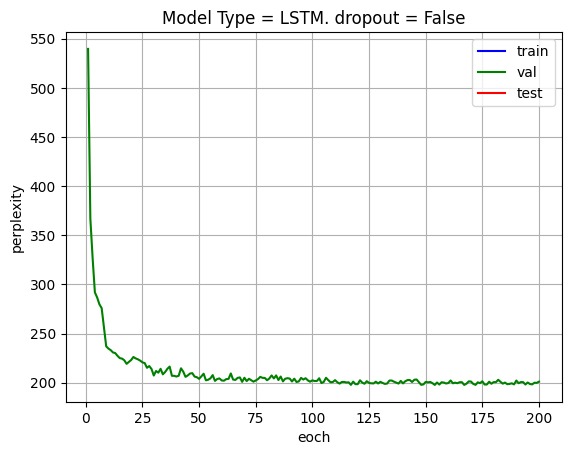

array([], dtype=float64)

In [18]:
plot_results(results_m)
results_m.train_ppl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')